In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [5]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [6]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [7]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [8]:
output_size = y_table.shape[0]

In [9]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [10]:
input_shape = x_test_2d_norm[0].shape

In [11]:
def build_2d_cnn_only_conv_ch_64_DO(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=64*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
#         x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [12]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_64_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 253, 95, 64)       1664      
_________________________________________________________________
activation (Activation)      (None, 253, 95, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 390144)            0         
_________________________________________________________________
dropout (Dropout)    

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5013 - acc: 0.5533
Epoch 00001: val_loss improved from inf to 1.30609, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_1_conv_checkpoint/001-1.3061.hdf5
36805/36805 [==============================] - 26s 708us/sample - loss: 1.5011 - acc: 0.5534 - val_loss: 1.3061 - val_acc: 0.6336
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0580 - acc: 0.6884
Epoch 00002: val_loss improved from 1.30609 to 1.14541, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_1_conv_checkpoint/002-1.1454.hdf5
36805/36805 [==============================] - 25s 677us/sample - loss: 1.0580 - acc: 0.6884 - val_loss: 1.1454 - val_acc: 0.6897
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8349 - acc: 0.7551
Epoch 00003: val_loss improved from 1.14541 to 1.08161, savin

36736/36805 [============================>.] - ETA: 0s - loss: 0.1205 - acc: 0.9682
Epoch 00028: val_loss did not improve from 1.03936
36805/36805 [==============================] - 27s 737us/sample - loss: 0.1205 - acc: 0.9682 - val_loss: 1.4542 - val_acc: 0.7466
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1118 - acc: 0.9696
Epoch 00029: val_loss did not improve from 1.03936
36805/36805 [==============================] - 27s 736us/sample - loss: 0.1116 - acc: 0.9697 - val_loss: 1.4341 - val_acc: 0.7508
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1086 - acc: 0.9713
Epoch 00030: val_loss did not improve from 1.03936
36805/36805 [==============================] - 27s 740us/sample - loss: 0.1087 - acc: 0.9713 - val_loss: 1.4248 - val_acc: 0.7524
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1012 - acc: 0.9739
Epoch 00031: val_loss did not improve from 1.03936
36805/36805 [==================

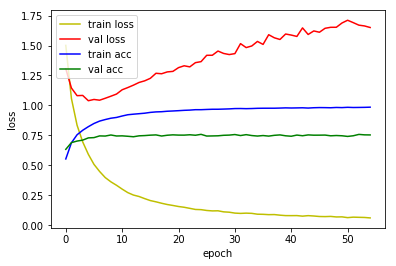

4815/4815 [==============================] - 2s 334us/sample - loss: 1.1255 - acc: 0.6941
Loss: 1.1255365388291896 Accuracy: 0.694081

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3852 - acc: 0.5893
Epoch 00001: val_loss improved from inf to 0.92140, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_2_conv_checkpoint/001-0.9214.hdf5
36805/36805 [==============================] - 33s 904us/sample - loss: 1.3853 - acc: 0.5893 - val_loss: 0.9214 - val_acc: 0.7512
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7581 - acc: 0.7775
Epoch 00002: val_loss improved from 0.92140 to 0.64455, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_2_conv_checkpoint/002-0.6446.hdf5
36805/36805 [==============================] - 33s 888us/sample - loss: 0.7581 - acc: 0.7775 - val_loss: 0.6446 - val_acc: 0.8262
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0436 - acc: 0.9868
Epoch 00028: val_loss did not improve from 0.44790
36805/36805 [==============================] - 32s 867us/sample - loss: 0.0436 - acc: 0.9868 - val_loss: 0.5753 - val_acc: 0.9089
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9883
Epoch 00029: val_loss did not improve from 0.44790
36805/36805 [==============================] - 32s 861us/sample - loss: 0.0423 - acc: 0.9883 - val_loss: 0.5760 - val_acc: 0.9036
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9888
Epoch 00030: val_loss did not improve from 0.44790
36805/36805 [==============================] - 32s 862us/sample - loss: 0.0402 - acc: 0.9888 - val_loss: 0.5899 - val_acc: 0.9047
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9889
Epoch 00031: val_loss did not improve from 0.44790
36805/36805 [=====

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9946
Epoch 00058: val_loss did not improve from 0.44790
36805/36805 [==============================] - 32s 870us/sample - loss: 0.0208 - acc: 0.9946 - val_loss: 0.6609 - val_acc: 0.9113
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0203 - acc: 0.9945
Epoch 00059: val_loss did not improve from 0.44790
36805/36805 [==============================] - 32s 865us/sample - loss: 0.0203 - acc: 0.9945 - val_loss: 0.6627 - val_acc: 0.9071

2D_CNN_only_conv_ch_64_DO_2_conv Model


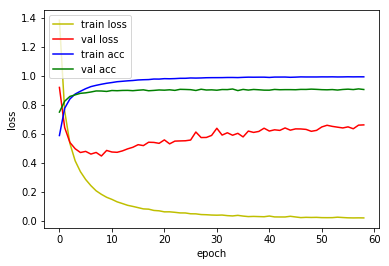

4815/4815 [==============================] - 2s 382us/sample - loss: 0.5588 - acc: 0.8596
Loss: 0.5588366856084805 Accuracy: 0.8596054

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3474 - acc: 0.5844
Epoch 00001: val_loss improved from inf to 0.72712, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_3_conv_checkpoint/001-0.7271.hdf5
36805/36805 [==============================] - 35s 962us/sample - loss: 1.3474 - acc: 0.5844 - val_loss: 0.7271 - val_acc: 0.8113
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6535 - acc: 0.8036
Epoch 00002: val_loss improved from 0.72712 to 0.48573, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_3_conv_checkpoint/002-0.4857.hdf5
36805/36805 [==============================] - 34s 932us/sample - loss: 0.6535 - acc: 0.8036 - val_loss: 0.4857 - val_acc: 0.8707
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.9851
Epoch 00026: val_loss did not improve from 0.23680
36805/36805 [==============================] - 34s 934us/sample - loss: 0.0485 - acc: 0.9851 - val_loss: 0.2853 - val_acc: 0.9488
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9862
Epoch 00027: val_loss did not improve from 0.23680
36805/36805 [==============================] - 34s 930us/sample - loss: 0.0456 - acc: 0.9862 - val_loss: 0.2740 - val_acc: 0.9504
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9858
Epoch 00028: val_loss did not improve from 0.23680
36805/36805 [==============================] - 34s 928us/sample - loss: 0.0438 - acc: 0.9858 - val_loss: 0.2930 - val_acc: 0.9474
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9873
Epoch 00029: val_loss did not improve from 0.23680
36805/36805 [=====

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9935
Epoch 00056: val_loss did not improve from 0.23680
36805/36805 [==============================] - 35s 939us/sample - loss: 0.0219 - acc: 0.9935 - val_loss: 0.3183 - val_acc: 0.9515
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9933
Epoch 00057: val_loss did not improve from 0.23680
36805/36805 [==============================] - 34s 929us/sample - loss: 0.0217 - acc: 0.9933 - val_loss: 0.3484 - val_acc: 0.9527
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0201 - acc: 0.9937
Epoch 00058: val_loss did not improve from 0.23680
36805/36805 [==============================] - 34s 929us/sample - loss: 0.0201 - acc: 0.9938 - val_loss: 0.3303 - val_acc: 0.9495
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9936
Epoch 00059: val_loss did not improve from 0.23680
36805/36805 [=====

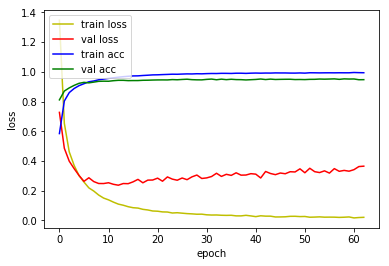

4815/4815 [==============================] - 2s 405us/sample - loss: 0.3301 - acc: 0.9138
Loss: 0.330093257375224 Accuracy: 0.913811

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5307 - acc: 0.5177
Epoch 00001: val_loss improved from inf to 0.72590, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_4_conv_checkpoint/001-0.7259.hdf5
36805/36805 [==============================] - 37s 992us/sample - loss: 1.5307 - acc: 0.5177 - val_loss: 0.7259 - val_acc: 0.7922
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7366 - acc: 0.7703
Epoch 00002: val_loss improved from 0.72590 to 0.44461, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_4_conv_checkpoint/002-0.4446.hdf5
36805/36805 [==============================] - 35s 961us/sample - loss: 0.7368 - acc: 0.7702 - val_loss: 0.4446 - val_acc: 0.8744
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0713 - acc: 0.9762
Epoch 00025: val_loss did not improve from 0.16340
36805/36805 [==============================] - 35s 960us/sample - loss: 0.0713 - acc: 0.9762 - val_loss: 0.1781 - val_acc: 0.9590
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0705 - acc: 0.9775
Epoch 00026: val_loss did not improve from 0.16340
36805/36805 [==============================] - 35s 962us/sample - loss: 0.0705 - acc: 0.9775 - val_loss: 0.1863 - val_acc: 0.9555
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0680 - acc: 0.9771
Epoch 00027: val_loss did not improve from 0.16340
36805/36805 [==============================] - 35s 957us/sample - loss: 0.0680 - acc: 0.9771 - val_loss: 0.1896 - val_acc: 0.9585
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0600 - acc: 0.9801
Epoch 00028: val_loss did not improve from 0.16340
36805/36805 [=====

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9911
Epoch 00055: val_loss did not improve from 0.16340
36805/36805 [==============================] - 35s 960us/sample - loss: 0.0297 - acc: 0.9911 - val_loss: 0.2058 - val_acc: 0.9623
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.9908
Epoch 00056: val_loss did not improve from 0.16340
36805/36805 [==============================] - 35s 959us/sample - loss: 0.0288 - acc: 0.9908 - val_loss: 0.2009 - val_acc: 0.9658
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9911
Epoch 00057: val_loss did not improve from 0.16340
36805/36805 [==============================] - 35s 960us/sample - loss: 0.0297 - acc: 0.9911 - val_loss: 0.1874 - val_acc: 0.9625
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0273 - acc: 0.9916
Epoch 00058: val_loss did not improve from 0.16340
36805/36805 [=====

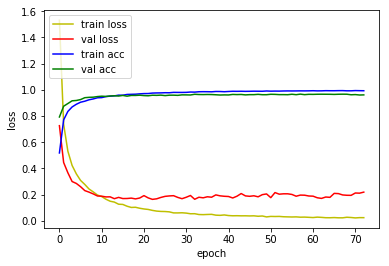

4815/4815 [==============================] - 2s 423us/sample - loss: 0.2518 - acc: 0.9387
Loss: 0.2518158720668912 Accuracy: 0.9387331



In [13]:
for i in range(1, 5):
    base = '2D_CNN_only_conv_ch_64_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_2d_cnn_only_conv_ch_64_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [19]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '2D_CNN_only_conv_ch_64_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 5):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


2D_CNN_only_conv_ch_64_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 253, 95, 64)       1664      
_________________________________________________________________
activation_10 (Activation)   (None, 253, 95, 64)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 48, 64)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 390144)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 390144)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 

In [20]:
def build_2d_cnn_only_conv_ch_64_BN(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=64*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
    x = BatchNormalization()(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [21]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_64_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 253, 95, 64)       1664      
_________________________________________________________________
batch_normalization_v1_19 (B (None, 253, 95, 64)       256       
_________________________________________________________________
activation_33 (Activation)   (None, 253, 95, 64)       0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 127, 48, 64)       0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 390144)            0         
_________________________________________________________________
batch_normalization_v1_20 (B (None, 390144)            1560576   
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1728 - acc: 0.5358
Epoch 00001: val_loss improved from inf to 2.81910, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_BN_1_conv_checkpoint/001-2.8191.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 3.1733 - acc: 0.5358 - val_loss: 2.8191 - val_acc: 0.5474
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6251 - acc: 0.7441
Epoch 00002: val_loss improved from 2.81910 to 2.51540, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_BN_1_conv_checkpoint/002-2.5154.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 1.6253 - acc: 0.7441 - val_loss: 2.5154 - val_acc: 0.6350
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0552 - acc: 0.8279
Epoch 00003: val_loss did not improve from 2.51540
36805/36805 [==============================] - 40s 1ms/sample 

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2309 - acc: 0.9740
Epoch 00030: val_loss did not improve from 2.42466
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.2309 - acc: 0.9740 - val_loss: 3.6430 - val_acc: 0.6683
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2111 - acc: 0.9766
Epoch 00031: val_loss did not improve from 2.42466
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.2110 - acc: 0.9766 - val_loss: 3.6130 - val_acc: 0.6769
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2021 - acc: 0.9779
Epoch 00032: val_loss did not improve from 2.42466
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.2024 - acc: 0.9778 - val_loss: 3.5783 - val_acc: 0.6795
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2302 - acc: 0.9745
Epoch 00033: val_loss did not improve from 2.42466
36805/36805 [===========

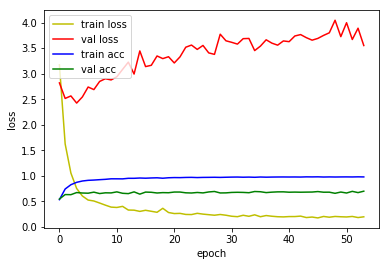

4815/4815 [==============================] - 3s 577us/sample - loss: 2.8057 - acc: 0.6353
Loss: 2.8057256582741426 Accuracy: 0.63530636

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3793 - acc: 0.6318
Epoch 00001: val_loss improved from inf to 1.06800, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_BN_2_conv_checkpoint/001-1.0680.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.3793 - acc: 0.6318 - val_loss: 1.0680 - val_acc: 0.7049
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5573 - acc: 0.8406
Epoch 00002: val_loss improved from 1.06800 to 0.82673, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_BN_2_conv_checkpoint/002-0.8267.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.5573 - acc: 0.8406 - val_loss: 0.8267 - val_acc: 0.8062
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9918
Epoch 00029: val_loss did not improve from 0.74085
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0301 - acc: 0.9918 - val_loss: 1.0759 - val_acc: 0.8411
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9929
Epoch 00030: val_loss did not improve from 0.74085
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0251 - acc: 0.9929 - val_loss: 1.3499 - val_acc: 0.8109
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9930
Epoch 00031: val_loss did not improve from 0.74085
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0251 - acc: 0.9930 - val_loss: 1.1644 - val_acc: 0.8365
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9908
Epoch 00032: val_loss did not improve from 0.74085
36805/36805 [===========

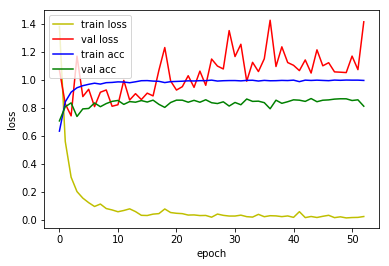

4815/4815 [==============================] - 3s 524us/sample - loss: 0.8222 - acc: 0.8114
Loss: 0.8222288572156912 Accuracy: 0.81142265

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2238 - acc: 0.6472
Epoch 00001: val_loss improved from inf to 0.81461, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_BN_3_conv_checkpoint/001-0.8146.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.2237 - acc: 0.6472 - val_loss: 0.8146 - val_acc: 0.7685
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5433 - acc: 0.8401
Epoch 00002: val_loss improved from 0.81461 to 0.51892, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_BN_3_conv_checkpoint/002-0.5189.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.5432 - acc: 0.8400 - val_loss: 0.5189 - val_acc: 0.8619
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9925
Epoch 00028: val_loss did not improve from 0.32426
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0265 - acc: 0.9925 - val_loss: 0.3953 - val_acc: 0.9301
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0168 - acc: 0.9957
Epoch 00029: val_loss did not improve from 0.32426
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0169 - acc: 0.9957 - val_loss: 0.4303 - val_acc: 0.9215
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9909
Epoch 00030: val_loss did not improve from 0.32426
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0302 - acc: 0.9909 - val_loss: 0.9028 - val_acc: 0.8409
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9919
Epoch 00031: val_loss did not improve from 0.32426
36805/36805 [===========


2D_CNN_only_conv_ch_64_BN_3_conv Model


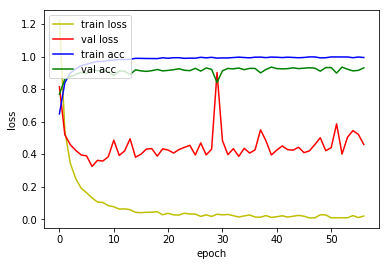

4815/4815 [==============================] - 3s 585us/sample - loss: 0.4014 - acc: 0.8868
Loss: 0.40137998328649616 Accuracy: 0.88681203

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2438 - acc: 0.6246
Epoch 00001: val_loss improved from inf to 0.76741, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_BN_4_conv_checkpoint/001-0.7674.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 1.2438 - acc: 0.6246 - val_loss: 0.7674 - val_acc: 0.7754
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5352 - acc: 0.8445
Epoch 00002: val_loss improved from 0.76741 to 0.44933, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_BN_4_conv_checkpoint/002-0.4493.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.5352 - acc: 0.8445 - val_loss: 0.4493 - val_acc: 0.8777
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9947
Epoch 00027: val_loss did not improve from 0.20137
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0228 - acc: 0.9947 - val_loss: 0.2020 - val_acc: 0.9488
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0138 - acc: 0.9973
Epoch 00028: val_loss improved from 0.20137 to 0.19288, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_BN_4_conv_checkpoint/028-0.1929.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0140 - acc: 0.9972 - val_loss: 0.1929 - val_acc: 0.9504
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.9929
Epoch 00029: val_loss did not improve from 0.19288
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0286 - acc: 0.9929 - val_loss: 0.2023 - val_acc: 0.9481
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0137 - ac

36800/36805 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9986
Epoch 00056: val_loss did not improve from 0.16410
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0062 - acc: 0.9986 - val_loss: 0.1997 - val_acc: 0.9536
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0068 - acc: 0.9985
Epoch 00057: val_loss did not improve from 0.16410
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0068 - acc: 0.9985 - val_loss: 0.1897 - val_acc: 0.9574
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0052 - acc: 0.9988
Epoch 00058: val_loss did not improve from 0.16410
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0052 - acc: 0.9988 - val_loss: 0.2340 - val_acc: 0.9474
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9991
Epoch 00059: val_loss did not improve from 0.16410
36805/36805 [========================

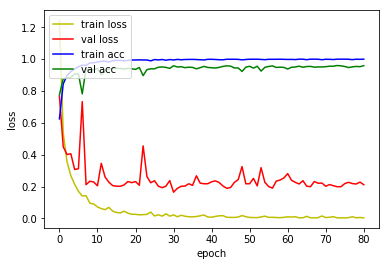

4815/4815 [==============================] - 3s 610us/sample - loss: 0.2386 - acc: 0.9310
Loss: 0.23859442047859897 Accuracy: 0.9310488



In [22]:
for i in range(1, 5):
    base = '2D_CNN_only_conv_ch_64_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_2d_cnn_only_conv_ch_64_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [23]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '2D_CNN_only_conv_ch_64_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 5):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


2D_CNN_only_conv_ch_64_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 253, 95, 64)       1664      
_________________________________________________________________
batch_normalization_v1_33 (B (None, 253, 95, 64)       256       
_________________________________________________________________
activation_43 (Activation)   (None, 253, 95, 64)       0         
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 127, 48, 64)       0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 390144)            0         
_________________________________________________________________
batch_normalization_v1_34 (B (None, 

4815/4815 [==============================] - 3s 634us/sample - loss: 0.2386 - acc: 0.9310
Loss: 0.23859442047859897 Accuracy: 0.9310488


In [24]:
def build_2d_cnn_only_conv_ch_64_DO_BN(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=64*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [25]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_64_DO_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 253, 95, 64)       1664      
_________________________________________________________________
batch_normalization_v1_47 (B (None, 253, 95, 64)       256       
_________________________________________________________________
activation_53 (Activation)   (None, 253, 95, 64)       0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 127, 48, 64)       0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 390144)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 390144)            0         
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8567 - acc: 0.4839
Epoch 00001: val_loss improved from inf to 2.41425, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_BN_1_conv_checkpoint/001-2.4143.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 2.8565 - acc: 0.4839 - val_loss: 2.4143 - val_acc: 0.5374
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0710 - acc: 0.6186
Epoch 00002: val_loss did not improve from 2.41425
36805/36805 [==============================] - 36s 986us/sample - loss: 2.0710 - acc: 0.6186 - val_loss: 2.5703 - val_acc: 0.5430
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7640 - acc: 0.6827
Epoch 00003: val_loss improved from 2.41425 to 2.11001, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_BN_1_conv_checkpoint/003-2.1100.hdf5
36805/36805 [==============================] - 36s 987

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2489 - acc: 0.9448
Epoch 00029: val_loss did not improve from 1.86547
36805/36805 [==============================] - 36s 979us/sample - loss: 0.2490 - acc: 0.9448 - val_loss: 2.1187 - val_acc: 0.7244
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2546 - acc: 0.9437
Epoch 00030: val_loss did not improve from 1.86547
36805/36805 [==============================] - 36s 983us/sample - loss: 0.2546 - acc: 0.9437 - val_loss: 2.3442 - val_acc: 0.7058
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2482 - acc: 0.9445
Epoch 00031: val_loss did not improve from 1.86547
36805/36805 [==============================] - 36s 984us/sample - loss: 0.2482 - acc: 0.9445 - val_loss: 2.1551 - val_acc: 0.7317
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2282 - acc: 0.9493
Epoch 00032: val_loss did not improve from 1.86547
36805/36805 [=====

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1784 - acc: 0.9659
Epoch 00059: val_loss did not improve from 1.86547
36805/36805 [==============================] - 36s 982us/sample - loss: 0.1784 - acc: 0.9659 - val_loss: 2.4854 - val_acc: 0.7233
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1638 - acc: 0.9697
Epoch 00060: val_loss did not improve from 1.86547
36805/36805 [==============================] - 36s 981us/sample - loss: 0.1637 - acc: 0.9697 - val_loss: 2.2661 - val_acc: 0.7452
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1774 - acc: 0.9657
Epoch 00061: val_loss did not improve from 1.86547
36805/36805 [==============================] - 36s 981us/sample - loss: 0.1775 - acc: 0.9657 - val_loss: 2.2988 - val_acc: 0.7442
Epoch 62/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1748 - acc: 0.9670
Epoch 00062: val_loss did not improve from 1.86547
36805/36805 [=====

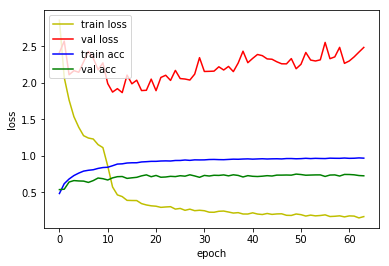

4815/4815 [==============================] - 3s 526us/sample - loss: 2.3139 - acc: 0.6721
Loss: 2.313942209433915 Accuracy: 0.67206645

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6045 - acc: 0.5264
Epoch 00001: val_loss improved from inf to 0.98931, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_BN_2_conv_checkpoint/001-0.9893.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 1.6043 - acc: 0.5265 - val_loss: 0.9893 - val_acc: 0.7119
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8901 - acc: 0.7285
Epoch 00002: val_loss improved from 0.98931 to 0.80319, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_BN_2_conv_checkpoint/002-0.8032.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.8902 - acc: 0.7285 - val_loss: 0.8032 - val_acc: 0.7598
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0949 - acc: 0.9712
Epoch 00027: val_loss did not improve from 0.48754
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0949 - acc: 0.9713 - val_loss: 0.5243 - val_acc: 0.8956
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0852 - acc: 0.9731
Epoch 00028: val_loss did not improve from 0.48754
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0852 - acc: 0.9731 - val_loss: 0.5570 - val_acc: 0.8987
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0859 - acc: 0.9740
Epoch 00029: val_loss did not improve from 0.48754
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0859 - acc: 0.9740 - val_loss: 0.6214 - val_acc: 0.8798
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0869 - acc: 0.9718
Epoch 00030: val_loss did not improve from 0.48754
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0330 - acc: 0.9909
Epoch 00057: val_loss did not improve from 0.48754
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0330 - acc: 0.9909 - val_loss: 0.5961 - val_acc: 0.9040
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9883
Epoch 00058: val_loss did not improve from 0.48754
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0387 - acc: 0.9883 - val_loss: 0.5861 - val_acc: 0.8975
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0367 - acc: 0.9900
Epoch 00059: val_loss did not improve from 0.48754
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0367 - acc: 0.9900 - val_loss: 0.7804 - val_acc: 0.8619
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9890
Epoch 00060: val_loss did not improve from 0.48754
36805/36805 [===========

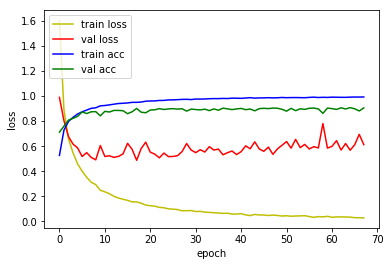

4815/4815 [==============================] - 3s 621us/sample - loss: 0.6195 - acc: 0.8613
Loss: 0.6195323860905252 Accuracy: 0.86126685

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5752 - acc: 0.5228
Epoch 00001: val_loss improved from inf to 0.79422, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_BN_3_conv_checkpoint/001-0.7942.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 1.5751 - acc: 0.5228 - val_loss: 0.7942 - val_acc: 0.7768
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7574 - acc: 0.7695
Epoch 00002: val_loss improved from 0.79422 to 0.54591, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_BN_3_conv_checkpoint/002-0.5459.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.7573 - acc: 0.7695 - val_loss: 0.5459 - val_acc: 0.8553
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0770 - acc: 0.9753
Epoch 00027: val_loss did not improve from 0.25493
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0770 - acc: 0.9753 - val_loss: 0.2808 - val_acc: 0.9373
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0739 - acc: 0.9766
Epoch 00028: val_loss did not improve from 0.25493
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0739 - acc: 0.9766 - val_loss: 0.2644 - val_acc: 0.9464
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0693 - acc: 0.9781
Epoch 00029: val_loss did not improve from 0.25493
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0693 - acc: 0.9781 - val_loss: 0.3125 - val_acc: 0.9313
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0674 - acc: 0.9786
Epoch 00030: val_loss did not improve from 0.25493
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9901
Epoch 00057: val_loss did not improve from 0.25493
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0337 - acc: 0.9901 - val_loss: 0.2774 - val_acc: 0.9515
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.9917
Epoch 00058: val_loss did not improve from 0.25493
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0280 - acc: 0.9917 - val_loss: 0.2783 - val_acc: 0.9504
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0328 - acc: 0.9907
Epoch 00059: val_loss did not improve from 0.25493
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0328 - acc: 0.9907 - val_loss: 0.3007 - val_acc: 0.9420
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9921
Epoch 00060: val_loss did not improve from 0.25493
36805/36805 [===========

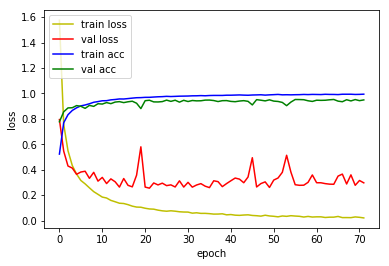

4815/4815 [==============================] - 3s 666us/sample - loss: 0.3180 - acc: 0.9221
Loss: 0.318027227629568 Accuracy: 0.92211837

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6818 - acc: 0.4807
Epoch 00001: val_loss improved from inf to 0.79087, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_BN_4_conv_checkpoint/001-0.7909.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 1.6817 - acc: 0.4807 - val_loss: 0.7909 - val_acc: 0.7899
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7686 - acc: 0.7604
Epoch 00002: val_loss improved from 0.79087 to 0.44922, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_DO_BN_4_conv_checkpoint/002-0.4492.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.7686 - acc: 0.7604 - val_loss: 0.4492 - val_acc: 0.8763
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0665 - acc: 0.9796
Epoch 00025: val_loss did not improve from 0.14601
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0665 - acc: 0.9796 - val_loss: 0.1687 - val_acc: 0.9595
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0665 - acc: 0.9790
Epoch 00026: val_loss did not improve from 0.14601
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0665 - acc: 0.9791 - val_loss: 0.1552 - val_acc: 0.9623
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0596 - acc: 0.9818
Epoch 00027: val_loss did not improve from 0.14601
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0596 - acc: 0.9819 - val_loss: 0.1790 - val_acc: 0.9578
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0607 - acc: 0.9811
Epoch 00028: val_loss did not improve from 0.14601
36805/36805 [========================

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9930
Epoch 00054: val_loss did not improve from 0.14535
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0255 - acc: 0.9930 - val_loss: 0.2067 - val_acc: 0.9553
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9933
Epoch 00055: val_loss did not improve from 0.14535
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0227 - acc: 0.9933 - val_loss: 0.2001 - val_acc: 0.9576
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9934
Epoch 00056: val_loss did not improve from 0.14535
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0229 - acc: 0.9934 - val_loss: 0.1780 - val_acc: 0.9613
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9923
Epoch 00057: val_loss did not improve from 0.14535
36805/36805 [===========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0157 - acc: 0.9954
Epoch 00084: val_loss did not improve from 0.14535
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0157 - acc: 0.9954 - val_loss: 0.2075 - val_acc: 0.9581
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0188 - acc: 0.9942
Epoch 00085: val_loss did not improve from 0.14535
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0188 - acc: 0.9942 - val_loss: 0.1763 - val_acc: 0.9646
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9957
Epoch 00086: val_loss did not improve from 0.14535
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0141 - acc: 0.9957 - val_loss: 0.2105 - val_acc: 0.9611
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9966
Epoch 00087: val_loss did not improve from 0.14535
36805/36805 [===========

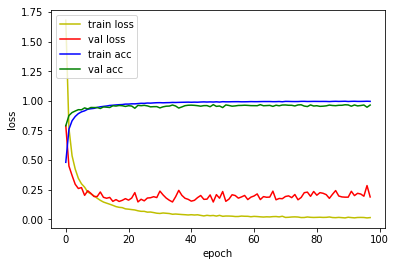

4815/4815 [==============================] - 3s 681us/sample - loss: 0.2307 - acc: 0.9452
Loss: 0.23067658747046382 Accuracy: 0.94517136



In [26]:
for i in range(1, 5):
    base = '2D_CNN_only_conv_ch_64_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_2d_cnn_only_conv_ch_64_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [27]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '2D_CNN_only_conv_ch_64_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 5):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)
        
        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


2D_CNN_only_conv_ch_64_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 253, 95, 64)       1664      
_________________________________________________________________
batch_normalization_v1_57 (B (None, 253, 95, 64)       256       
_________________________________________________________________
activation_63 (Activation)   (None, 253, 95, 64)       0         
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 127, 48, 64)       0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 390144)            0         
_________________________________________________________________
dropout_12 (Dropout)         (Non

4815/4815 [==============================] - 3s 712us/sample - loss: 0.2307 - acc: 0.9452
Loss: 0.23067658747046382 Accuracy: 0.94517136
